# Portfolio optimization

Portfolio optimization is an important part of many quantitative strategies. You take some inputs related to risk and return and you try to find the portfolio with the desired characteristics. Those characteristics might be something like the best risk-reward trade-off, often given with a Sharpe Ratio. Or, you might be trying to find a portfolio with a particular expected return and the lowest possible risk to get that return. 

We'll start with the example of portfolio optimization using `scipy.optimize`, very similar to the code found in Chapter 13 of our textbook. This is very much like using **Solver in Excel**. You are having Python numerically solve an optimization problem with some set of constraints or limits on the answer. This means that Python will try to guess values until it gets really, really close to the "best" possible solution.

We are also going to see some interesting Python. We'll use **tuples**, a basic (primitive) data type in Python. We have **for** loops. We'll **define our own functions**. We'll even use something called a **lambda function**. 

Finally, we'll use the `PyPortfolioOpt` [package](https://pypi.org/project/pyportfolioopt/), which is also discussed in the DataCamp assignments. This lets us avoid some of the more math-like aspects of using `scipy.optimize` and have a library do the work for us using more familiar finance terms. Still, I think it is really important to understand at least a little bit about the optimization process itself. These tools are used in all sorts of applications.


## Getting started
Let's bring in our usual set of prices, pick four assets, calculate **discrete** returns, and plot a histogram of those returns.

We are going to use **discrete** (or simple, or arithmetic) returns instead of **log** returns, because we are doing **portfolio optimization**. In short, the return of a portfolio is the weighted average of the mean discrete returns. This is not true for mean log returns.

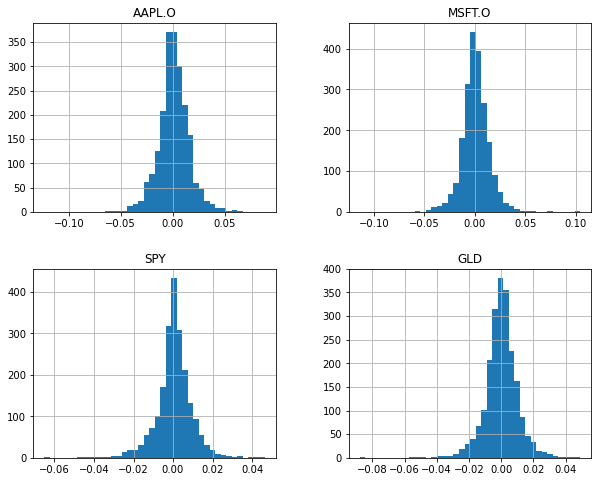

In [1]:
# Read in some eod prices
import numpy as np
import pandas as pd

from pylab import mpl, plt

import scipy.optimize as sco

raw = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna() 

symbols = ['AAPL.O', 'MSFT.O', 'SPY', 'GLD'] #two stocks and two ETFs

noa = len(symbols) #noa = number of assets

data = raw[symbols]

rets = data.pct_change().dropna()

rets.hist(bins=40, figsize=(10, 8));

In [2]:
rets.describe()

,AAPL.O,MSFT.O,SPY,GLD
count,2137.000000,2137.000000,2137.000000,2137.000000
mean,0.000969,0.000643,0.000452,0.000088
std,0.015900,0.014221,0.009313,0.010170
min,-0.123549,-0.113995,-0.065123,-0.087808
25%,-0.006883,-0.006745,-0.003418,-0.005084
50%,0.000667,0.000308,0.000580,0.000343
75%,0.009597,0.007896,0.005071,0.005317
max,0.088741,0.104522,0.046499,0.049122


```{note}
These four return series each have the same number of observations. This is important when doing correlation and covariance matrices. You'll likely want to just keep observations where none of the assets have missing returns. This is another reason why using historical data can be tricky - for a lot of specific assets, we just don't have much data!
```

We can the average daily return of each of these four sets of discrete returns and annualize them. You can annualize daily log returns by multiplying by 252, the number of trading days in a year. You can not do this with discrete returns, or $\frac{P_t}{P_{t-1}} - 1$. Instead, you **compound them and do $(1+dailyaverage)^{252} - 1$.

In [3]:
(1+rets.mean())**252-1

AAPL.O    0.276592
MSFT.O    0.175962
SPY       0.120612
GLD       0.022462
dtype: float64

In [4]:
ann_rets = (1+rets.mean())**252-1

Same thing with variance and covariance. We are going to take a short-cut and annualize the daily variances and covariances by multiplying by 252. You would annualize standard deviation by multiplying by $\sqrt{252}$. Technically, you should only do this with log returns.

In [5]:
rets.cov() * 252

,AAPL.O,MSFT.O,SPY,GLD
AAPL.O,0.063710,0.023364,0.021015,0.001497
MSFT.O,0.023364,0.050965,0.022193,-0.000337
SPY,0.021015,0.022193,0.021858,0.000041
GLD,0.001497,-0.000337,0.000041,0.026063


When you form a portfolio, you of course need to know how much of your portfolio is in each asset. Let's pick some **random weights** to start. We'll do that by choosing random numbers between 0 and 1. How many random numbers? The variable *noa* has the number of assets stored in it, so we'll pick four. Then, we'll divide each random number by the sum of the four numbers. This "trick" let's us go from four numbers between 0 and 1 to four numbers that will add up to 1. Just like portfolio weights!

Note the `/=`. This divides every item in *weights* by the sum of the weights and then saves the result back to *weights*.

In [6]:
weights = np.random.random(noa)
weights /= np.sum(weights)

In [7]:
weights.sum()

1.0

Good! They add up to 1. Or, well, basically 1. Remember, computers try their best to store exact numbers, but there's only so much precision that you can get. 

In [8]:
np.sum(ann_rets * weights)

0.18463745244112048

We can also find portfolio variance using the random weights. Again, we're annualizing variances and covariances.

In [9]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.028430199853552843

Finally, we take the square root of variance to get standard deviation. 

In [10]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.1686125732368522

Ok, all of this was with random weights. Can we do any better than that, if we assume that our expected returns and variance co-variance matrix represent our best guess about how these assets will behave in the future? Note that his is a really big assumption. The past might not tells us much about the future.

## Plotting the efficient frontier

The efficient frontier represents the relationship between risk and return. Each point on the curve is the best return that you can get for a given level of risk. Or, equivalently, each point is the lowest risk that you can take for a particular expected return. We would expect to see a positive relationship between risk and return. 

```{figure} ../images/10-cal.png
---
name: 10-cal_2.png
align: center
---
The Capital Allocation Line, or CAL. The mean-variance frontier is the highest return you can get for a given level of risk. The CAL is all possible combinations have the highest Sharpe Ratio portfolio (the tangency portfolio) and the risk-free asset. If all investors have the same beliefs about all underlying assets, then they will all hold the same market portfolio, just in different quantities, depending on their risk preferences. Source: Asset Management by Andrew Ang
```

What if we picked a bunch of random portfolios, found their risk and return, and then plotted each on a scatter plot? We should see the efficient frontier "emerge" as we essentially throw darts, since some risk-return combinations are not possible for a given set of assets. There's only so much return you can get for a given level of risk. 

To do this, let's define two functions. One just takes weights and finds the portfolio return using the mean returns. The other finds the volatility of the portfolio using the weights passed to it. Note that both are just the formulas used above, but now in a function that we've defined. 

How do you **read the format of a user defined function**? You use `def` to define the function name. Inside of `()`, you put the items that are getting passed, or given to, the function. In this case, whatever we give the function will be called *weights* inside of the function. What's inside the function. You must end the first line with a `:`. Then, you need to **indent everything that happens when the function is used**. In this case, that's just one line. The function will **return** whatever is on the line with **return**. In this case, the portfolio return and volatility. 

In [11]:
def port_ret(weights):
    return np.sum(ann_rets * weights)

In [12]:
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

Here's the main part. We are going to use those two functions above to write some cleaner code. We start by creating two empty arrays, *prets* and *pvols*. We'll then put a bunch of different portfolio mean returns and volatilities into these arrays. How are we going to get these different portfolio risk and return characteristics? Let's create a bunch of random portfolios with random asset weights. In fact, let's create 2500 random portfolios and see what each combination of risk and return looks like when we plot it. The shape should look familiar!

In [13]:
prets = []
pvols = []
for p in range (2500):  
    weights = np.random.random(noa)  
    weights /= np.sum(weights)  
    prets.append(port_ret(weights))  
    pvols.append(port_vol(weights))  
prets = np.array(prets)
pvols = np.array(pvols)

The **for** statement will have the value *p* go from 0 to 2499 (i.e. 2500 times). For each of these times through the loop, we calculate our random weights and the portfolio returns and volatility for these weights, using the same expected returns and volatility for the assets each time through. Only the weights are changing. We then **append**, or stack, the return and volatility values on top of each other, creating two **lists** with 2500 numbers in them. But, we don't want a list. We want an **array** of numbers. The last two lines convert the lists into `numpy` arrays which we can graph.

Let's graph them. We'll make a **scatter plot** with volatility on the x-axis and returns on the y-axis. The `c=` option adds a third dimension to the graph, where we pick a color for each dot based on another value. That value is the return for that dot divided by the volatility of that dot. In other words, darker red means bigger return over risk ratio, or larger **Sharpe Ratio**. Notice how the dark red is along the edge of the curve? This is the **efficient frontier**! 

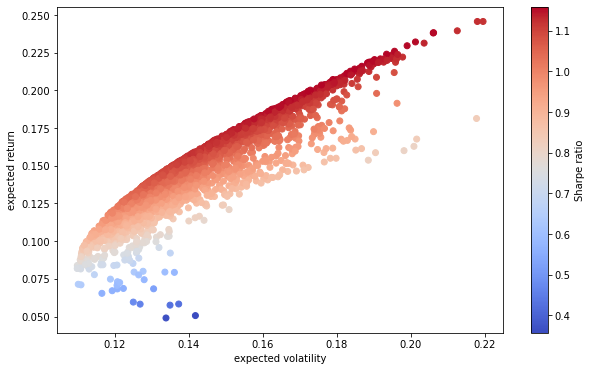

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
            marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

We've just generated the **efficient frontier** from a simulation. No "formulas", per se. Just make 2500 random portfolios and at least some of them are going to be good!

Each portfolio on the **envelope**, the edge of the shape we see above, is on the efficient frontier. Each of these portfolios has the highest return for a given level of risk (or the lowest risk for a given return). 

We'll draw the efficient frontier below. 

## Optimizing

Let's use an **optimizer** actually find the portfolio with the best Sharpe Ratio. This will be, for a given risk-free rate, the single portfolio with the best risk-reward trade-off. 

We'll also find the portfolio with the lower volatility (risk). This portfolio is sometimes called the **minimum variance portfolio**.

We will assume in this example that the risk-free rate is zero. We are not subtracting the risk-free rate from the portfolio return in the numerator. Note that as you change the risk-free rate, then you get different maximum Sharpe Ratio portfolios. What you're doing, graphically, is **tracing** out the efficient frontier, finding different porfolios that are on the envelope. 

### Finding the max Sharpe portfolio
We'll start by defining a new function. This is our **Sharpe Ratio**. The optimization process that we're going to use wants to find the **minimum** of something. So, we'll make the Sharpe Ratio negative. This will then be the equivalent of finding the **maximum. 

In [15]:
def min_func_sharpe(weights):  
    return -port_ret(weights) / port_vol(weights)  

That's the function that we are going to **minimize**. We are going to have Python find the weights that make that function as small as possible. Again, since the function has a negative sign in front, this is like finding the maximum. 

Portfolio optimization always has a **constraint** where your weights must add up to one. To add this constraint, we are now going to set up a **dictionary** that our optimizer is going to be able to understand. The dictionary will say that we are going to give the optimizer something that is type `eq`, or an equation, and that the equation is the sum of all of our weights minus 1. The optimizer is going to know that we want this to be set equal to zero when solving for weights. In other words, all of our weights must add up to one - we are forcing the optimizer to to this.

By the way, see the `lambda x:`? This is a **lambda**, or anonymous, function. These let us quickly and easily define a simple function. In this case, we have a function that is going to take an argument *x* and then do something with it. We are adding up all of the elements of *x* and then subtracting one. When we use this function, *x* will be our weights.

In [16]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
type(cons)

dict

We can now put some bounds on our weights. Weights, in this case, need to be between 0 and 1. This isn't always the case! For example, short-selling means having weights less than 0. Leverage means weights greater than 1, potentially. To do this, we'll create a **tuple** that has the set (0,1) for each asset in our portfolio, four in this case. This will tell the optimizer to keep each asset weight between 0 and 1.

In [17]:
bnds = tuple((0, 1) for x in range(noa))  
bnds

((0, 1), (0, 1), (0, 1), (0, 1))

We'll start by giving the optimizer an equally-weighted portfolio. It will change these weights to find the ones that minimize that negative Sharpe Ratio. This code will generate an array with equal weights, no matter how many assets you are using.

In [18]:
eweights = np.array(noa * [1. / noa,])  
eweights  

array([0.25, 0.25, 0.25, 0.25])

Here's the negative Sharpe Ratio with the equal-weights. So, the "real" Sharpe is 1.09.

In [19]:
min_func_sharpe(eweights)

-1.0908488751504752

Finally, let's use the optimizer! We are going to use `sco.minimize` from the library `SciPy`, which we have brought in above. This function is like **Solver in Excel**. It is going to find the minimum value of some function by changing a set of variables in the function, subject to some constraints. The first argument is the function to minimize. The second argument is the initial guess. Then, we give it the method to use to find the minimum value. We're using something called Sequential Least Squares Programming (SLSQP) here. Not important for us. We then give the optimizer our bounds for the variables and the constraints.

You can read more about this function in the `SciPy` manual [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). 

In [20]:
opts = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons) 
type(opts)

scipy.optimize.optimize.OptimizeResult

We've saved the results in this OptimizeResult **object**. This object contains information about our optimization, including the optimal values it found. It calls these *x* - they are our weights that give us the minimum negative (i.e. maximum) Sharpe Ratio.

In [21]:
opts

     fun: -1.1598432135999732
     jac: array([-0.00023924,  0.00011204,  0.00012445,  0.00091708])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.56886419, 0.25891539, 0.06413075, 0.10808967])

Let's pull out just the weights from the object and round to three decimal palces.

In [22]:
opts['x'].round(3)  

array([0.569, 0.259, 0.064, 0.108])

Here's the portfolio return with those weights.

In [23]:
port_ret(opts['x']).round(3)  

0.213

And the portfolio volatility with those weights.

In [24]:
port_vol(opts['x']).round(3)  

0.184

And, the Sharpe Ratio with those weights.

In [25]:
port_ret(opts['x']) / port_vol(opts['x'])  

1.1598432135999732

### Finding the minimum variance portfolio. 

We can do the same things and find the set of weights that **minimize portfolio variance**. Instead of minimizing the negative of the Sharpe Ratio, we'll minimize the function that contains the formula for portfolio volatility, *port_vol*. 

In [26]:
optv = sco.minimize(port_vol, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)  

In [27]:
optv


     fun: 0.10912534155379648
     jac: array([0.11099017, 0.10919402, 0.10910396, 0.10915083])
 message: 'Optimization terminated successfully'
    nfev: 45
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.40946282e-18, 0.00000000e+00, 5.43849155e-01, 4.56150845e-01])

In [28]:
optv['x'].round(3)

array([0.   , 0.   , 0.544, 0.456])

Nothing in our first asset, Apple. Since we are just minimizing variance, we don't care about Apple's nice return over this period. 

We can find the Sharpe Ratio for the minimum variance portfolio. Note how it is lower!

Also, finding minimum variance and minimum volatility are the **same thing**, since volatility is just the square root of variance.

In [29]:
port_vol(optv['x']).round(3)

0.109

In [30]:
port_ret(optv['x']).round(3)

0.076

In [31]:
port_ret(optv['x']) / port_vol(optv['x'])

0.6949874073267915

## Efficient Frontier

Let's now trace out the actual **efficient frontier**. We are going to follow an "algorithm", so to speak. Here are the steps:

1) Pick a target return.
2) Find the portfolio that gives you the minimum portfolio standard deviation (volatility) for that target return.
3) Repeat this process for a large number of target returns.

These steps will find a bunch of different portfolios, all that live on the envelope of the set containing all of the possible portfolios. These are the portfolios on the efficient frontier. 

To do this, we now need two constraints. First, we want our portfolio return to be equal to some target return, *tret*. Second, we again have our weights must sum to one constraint.

Both of these constraints can live inside of the *cons* tuple. This **tuple** contains two **dictionaries**. Kind of confusing, but we just need to understand the syntax for writing out different constraints. The only part that changes is the code after `lambda x:`. 

In [32]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
type(cons)

tuple

Our bounds again, same as before.

In [33]:
bnds = tuple((0, 1) for x in weights)

Let's create an **array** of values from 0.05 to 0.20. This represents a minimum of a 5% return and a maximum of a 20% return. We'll do 50 evenly-spaced values. Each one of these represents one target return. We are going to find and store the minimum volatility that gives us each return.

In [34]:
trets = np.linspace(0.05, 0.2, 50)
print(type(trets))
trets

<class 'numpy.ndarray'>


array([0.05      , 0.05306122, 0.05612245, 0.05918367, 0.0622449 ,
       0.06530612, 0.06836735, 0.07142857, 0.0744898 , 0.07755102,
       0.08061224, 0.08367347, 0.08673469, 0.08979592, 0.09285714,
       0.09591837, 0.09897959, 0.10204082, 0.10510204, 0.10816327,
       0.11122449, 0.11428571, 0.11734694, 0.12040816, 0.12346939,
       0.12653061, 0.12959184, 0.13265306, 0.13571429, 0.13877551,
       0.14183673, 0.14489796, 0.14795918, 0.15102041, 0.15408163,
       0.15714286, 0.16020408, 0.16326531, 0.16632653, 0.16938776,
       0.17244898, 0.1755102 , 0.17857143, 0.18163265, 0.18469388,
       0.1877551 , 0.19081633, 0.19387755, 0.19693878, 0.2       ])

And here's the optimization process. We start with an empty array that will eventually contain 50 different volatilities (standard deviations). Then, we loop through each target return in *trets*. Each one gets stored in *tret* and used in the For loop. The optimizer uses that target return as part of the constraint function that we included. We are then storing the value of the minimized portfolio volatility function in *tvols*. Note that we are not storing the weights for each portfolio. We only care about the minimum volatilities for each return.

In [35]:
%%time
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',
                       bounds=bnds, constraints=cons)  
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 9.61 s, sys: 133 ms, total: 9.74 s
Wall time: 1.23 s


And now we can plot our efficient frontier. The efficient frontier is each **target return, minimum volatility pair**. That blue line is the frontier and is being added by the first `plt.plot` statement. The second `plt.plot` adds the yellow star at the max Sharpe Ratio portfolio. The third `plt.plot` adds the red star at the global minimum variance portfolio. Notice how both of these are pulling the weights, *x*, out of their respective Optimizer objects. 

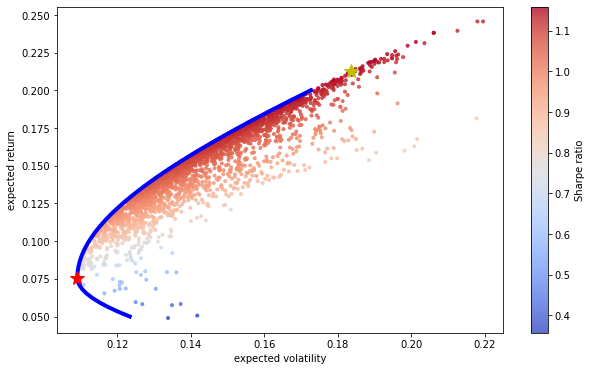

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
            marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']),
         'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']),
         'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

## PyPortfolioOpt

To get started, you'll need to type `pip install PyPortfolioOpt` in your Terminal below. This will install the package, since it doesn't come with Anaconda. We can then bring in what we need.

You can read all about the `PyPortfolioOpt` package [here](https://pypi.org/project/pyportfolioopt/).

You can also find examples on the author's [Github page](https://github.com/robertmartin8/PyPortfolioOpt/tree/master/cookbook). The creator of this package runs a data/macro strategy consulting firm.

```{figure} ../images/09-pyport.png
---
name: 09-pyport.png
align: center
---
The portfolio optimization process. Source: PyPortfolioOpt
```

This [page](https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html) takes the explanations on the Github page and provides some nicer formatting.

In [37]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting

We can find expected returns and the sample variance-covariance matrix using functions from `PyPortfolioOpt`. Notice that these functions want prices, not returns, by default. So, I'm using the DataFrame *data*, not *ret*. You can change this setting with the argument `returns_data = True`. 

I'll start by finding returns from prices. 


In [38]:
rets_pyp = expected_returns.returns_from_prices(data)
rets_pyp 

,AAPL.O,MSFT.O,SPY,GLD
Date,,,,
2010-01-05,0.001729,0.000323,0.002647,-0.000911
2010-01-06,-0.015906,-0.006137,0.000704,0.016500
2010-01-07,-0.001849,-0.010335,0.004221,-0.006188
2010-01-08,0.006648,0.006830,0.003328,0.004963
2010-01-11,-0.008822,-0.012720,0.001397,0.013289
...,...,...,...,...
2018-06-25,-0.014871,-0.020118,-0.013613,-0.003739
2018-06-26,0.012406,0.007013,0.002214,-0.005255
2018-06-27,-0.001464,-0.015543,-0.008284,-0.005702


In [42]:
rets

,AAPL.O,MSFT.O,SPY,GLD
Date,,,,
2010-01-05,0.001729,0.000323,0.002647,-0.000911
2010-01-06,-0.015906,-0.006137,0.000704,0.016500
2010-01-07,-0.001849,-0.010335,0.004221,-0.006188
2010-01-08,0.006648,0.006830,0.003328,0.004963
2010-01-11,-0.008822,-0.012720,0.001397,0.013289
...,...,...,...,...
2018-06-25,-0.014871,-0.020118,-0.013613,-0.003739
2018-06-26,0.012406,0.007013,0.002214,-0.005255
2018-06-27,-0.001464,-0.015543,-0.008284,-0.005702


We can compare that with our original return file and see that this function is calculating discrete returns by default, since the returns are the same. We can use the package to find annualized returns too. I'll give the function the price data again. I will also set compounding to False, as I don't want geometric means (CAGRs) for portfolio optimization. I want arithmetic means. The default for this function is that you have daily returns, or 252 time periods. Just like above. 

But, I'll add each option, just so that you can that they are there.

In [45]:
mu = expected_returns.mean_historical_return(data, compounding = False, log_returns = False, frequency = 252)
mu

AAPL.O    0.244313
MSFT.O    0.162139
SPY       0.113901
GLD       0.022214
dtype: float64

You can actually see the [code for these functions](https://github.com/robertmartin8/PyPortfolioOpt/blob/master/pypfopt/expected_returns.py). I like looking through code like this to both learn what these functions are doing, what my options are, etc., as well as learning how to write better Python myself!

You'll note that the annualized returns are different from the ones I got above. If you follow the code for this function, that's because, with the options that I've chosen, the function is taking the average daily return and multiplying by 252 to get the annual return, even though these are discrete, and not log, returns.

You can see that by taking my returns and doing the multiplication ourselves.

In [47]:
rets.mean()*252

AAPL.O    0.244313
MSFT.O    0.162139
SPY       0.113901
GLD       0.022214
dtype: float64

Which approach is right? We'll go with these numbers for this example. I hope that you're seeing that some of these basic data choices aren't necessarily obvious or consistent among practitioners!

The package author has a good comment in his documents about the issues with using historical data for returns: 

> This is probably the default textbook approach. It is intuitive and easily interpretable,
    however the estimates are subject to large uncertainty. This is a problem especially in the
    context of a mean-variance optimizer, which will maximise the erroneous inputs.

In other words, the assets with the largest historical returns are likely the assets with the greatest estimation error. But, the simplest optimization methods, like what we're doing, will choose those assets! And, the same is true for the worst performing assets. Their negative performance might be exaggerated too. 


Next, we can create and store the **sample variance-covariance matrix**. "Sample" means that we are using sample variance and covariance (as opposed to population variance and covariance). 

In [39]:
S = risk_models.sample_cov(data)
S

,AAPL.O,MSFT.O,SPY,GLD
AAPL.O,0.063710,0.023364,0.021015,0.001497
MSFT.O,0.023364,0.050965,0.022193,-0.000337
SPY,0.021015,0.022193,0.021858,0.000041
GLD,0.001497,-0.000337,0.000041,0.026063


`PyPortfolioOpt` has built-in plotting functions that create `matplotlib` plots, among other plot types. Here's one showing the correlations among our four assets. Gold immediately stands out.

<AxesSubplot:>

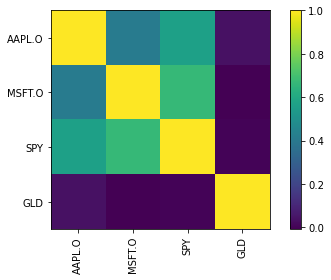

In [40]:
plotting.plot_covariance(S, plot_correlation=True)

Let's find our max Sharpe portfolio. We'll do this step-by-step. First, we'll use the function `EfficientFrontier` to find and create an object that contains the information needed to describe the efficient frontier for these assets. Note that you just need the expected returns and the variance-covariance matrix to define the efficient frontier. 

In [49]:
ef = EfficientFrontier(mu, S)
ef

This *ef* object contains useful things. For example, it let's us pull our the max Sharpe portfolio for a given risk-free rate. Remember, you pick a risk-free rate and draw that tangency line over to the efficient frontier. So, different assumed risk-free rates give you different max Sharpe portfolios. 

In [50]:
raw_weights = ef.max_sharpe(risk_free_rate = 0.025)
raw_weights


OrderedDict([('AAPL.O', 0.688149209643207),
             ('MSFT.O', 0.311850790356793),
             ('SPY', 0.0),
             ('GLD', 0.0)])

This comes out as a type of **Dictionary**. We can use `clean_weights()` to get rid of some of the decimal places.

In [52]:
cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('AAPL.O', 0.68815),
             ('MSFT.O', 0.31185),
             ('SPY', 0.0),
             ('GLD', 0.0)])

Finally, we can pull out the return and risk characteristics of this max Sharpe portfolio with that assumed risk-free rate. 

In [54]:
perf = ef.portfolio_performance(verbose=True, risk_free_rate = 0.025)
perf

Expected annual return: 21.9%
Annual volatility: 21.2%
Sharpe Ratio: 0.91


(0.21868665539725798, 0.2124945591992392, 0.9114899512116612)

You can even access the individual values in this *perf* `tuple` I created. Here's the expected annual return

In [59]:
type(perf)

tuple

In [60]:
perf[0]

0.21868665539725798

This package does much more than this. I encourage you to take a look! Here's one additional example, with some weight bounds for the assets added to the `EfficientFrontier` method. See how Apple hits the upper limit I set of 50%? Apple did so well during this period that the optimizer really wants us to put most of money in it. Is that a good idea?

In [62]:
ef = EfficientFrontier(mu, S, weight_bounds=(-0.2, 0.5))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AAPL.O', 0.5), ('MSFT.O', 0.28465), ('SPY', 0.15223), ('GLD', 0.06311)])
Expected annual return: 18.7%
Annual volatility: 18.0%
Sharpe Ratio: 0.93


(0.18705115513924062, 0.18034328618093198, 0.9262953929521067)